https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from scipy.signal import find_peaks

2024-01-16 17:29:37.532386: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 17:29:37.567716: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 17:29:37.777028: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 17:29:37.777125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 17:29:37.799063: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


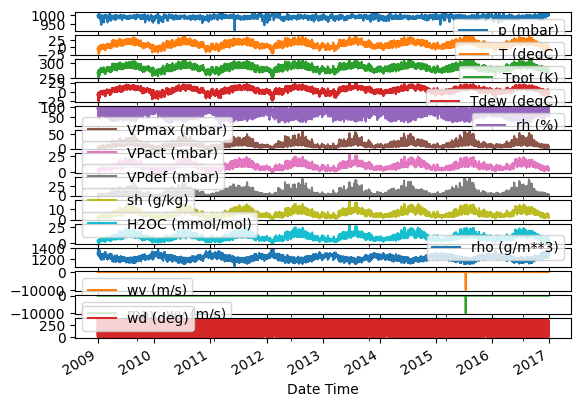

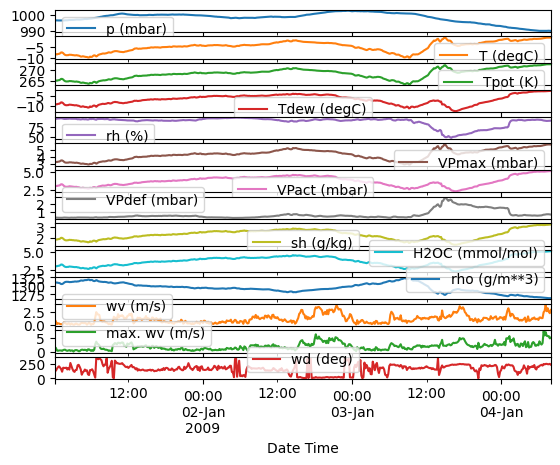

In [3]:
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

cols = ['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
        'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
        'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
        'wd (deg)']

plot_features = df[cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [4]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [5]:
wv = df['wv (m/s)']
wv_max = df['max. wv (m/s)']
bad_wv = wv == -9999.0
bad_wv_max = wv_max == -9999.0
wv[bad_wv] = 0.0
wv_max[bad_wv_max] = 0.0
df['wv (m/s)'].min()

0.0

Text(0, 0.5, 'wd (deg)')

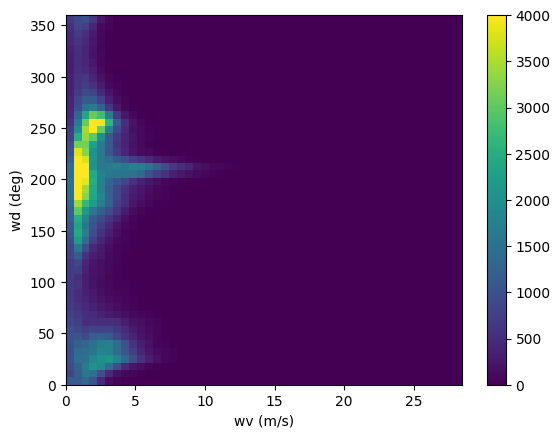

In [6]:
plt.hist2d(df['wv (m/s)'], df['wd (deg)'], bins=(50,50), vmax=4000)
plt.colorbar()
plt.xlabel('wv (m/s)')
plt.ylabel('wd (deg)')

## Convert wind direction and velocity to windvectors
$W_x = cos(d) \cdot v$
$W_y = sin(d) \cdot v$

Text(0, 0.5, 'y m/s')

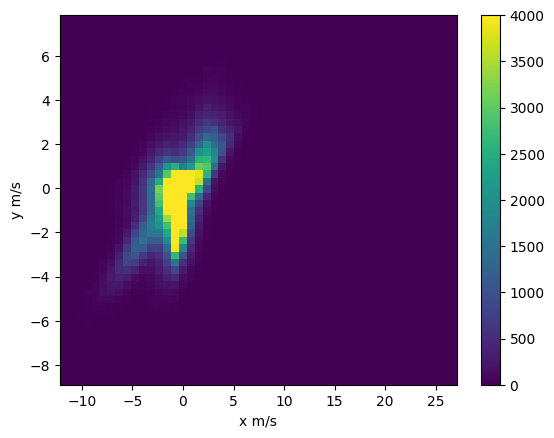

In [7]:
wv = df['wv (m/s)']
wd = df['wd (deg)'] * np.pi / 180.  # convert to radians
df['Wx'] = np.cos(wd) * wv
df['Wy'] = np.sin(wd) * wv

plt.hist2d(df['Wx'], df['Wy'], bins=(50,50), vmax = 4000)
plt.colorbar()
plt.xlabel('x m/s')
plt.ylabel('y m/s')

In [8]:
timestamp = date_time.map(pd.Timestamp.timestamp)

[1997489.2   445689.12]
important frequencies: [   8 2921]


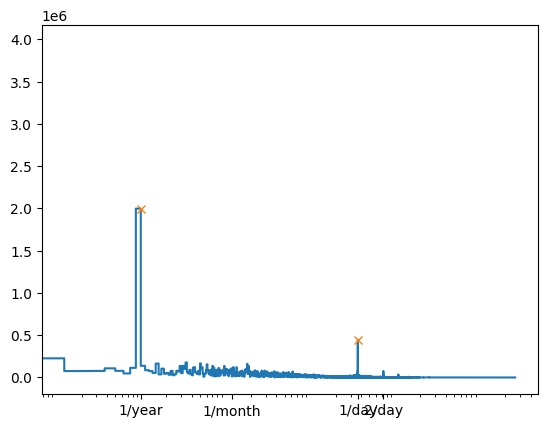

In [9]:
# check for important frequencies via fft
fft_temp = tf.signal.rfft(df['T (degC)'])
abs_fft_temp = np.array(abs(fft_temp))
n_freq = np.arange(0, len(fft_temp))
n_samples = len(df['T (degC)'])
hours = n_samples / 6
hours_per_year = 24 * 365.2524
f_per_year = n_freq / (hours / hours_per_year)
plt.xscale('log')

peaks, _ = find_peaks(abs_fft_temp, prominence=400000., distance=100)
peak_y = abs_fft_temp[peaks]
print(peak_y)
plt.step(f_per_year, abs_fft_temp)
plt.plot(peaks/ (hours / hours_per_year), peak_y, 'x')
plt.xticks([1, 12, 365.2524, 365.252 * 2], ['1/year', '1/month', '1/day', '2/day'])
print(f"important frequencies: {peaks}")

Text(0, 0.5, 'Time Signal')

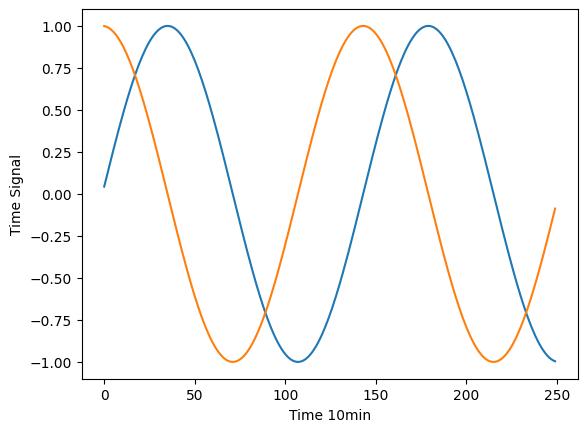

In [10]:
day = 24 * 60 * 60
year = 365.2425 * day
df['day sin'] = np.sin(timestamp * (2 * np.pi / day))
df['day cos'] = np.cos(timestamp * (2 * np.pi / day))
df['year sin'] = np.sin(timestamp * (2 * np.pi / year))
df['year cos'] = np.cos(timestamp * (2 * np.pi / year))

plt.plot(np.array(df['day sin'])[:250])
plt.plot(np.array(df['day cos'])[:250])
plt.xlabel('Time 10min')
plt.ylabel('Time Signal')

Text(0, 0.5, 'Time signal')

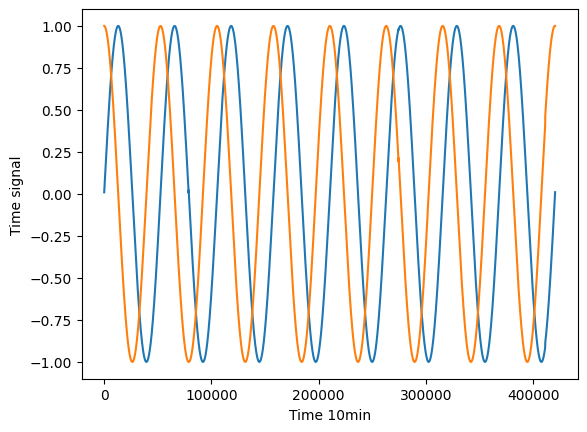

In [11]:
plt.plot(df['year sin'])
plt.plot(df['year cos'])
plt.xlabel('Time 10min')
plt.ylabel('Time signal')
# 8 years recording

In [12]:
# prepare trainingsdtata
# split (70, 20, 10)
# dont mix, since it's timeseries data

col_idx = { name: i for i, name in enumerate(df.columns)}
print(col_idx)

n = len(df)
train_df = df[0:int(.7 * n)]
val_df = df[int(.7*n):int(.9*n)]
test_df = df[int(.9*n):]

n_features = df.shape[1]

print(f"{n} samples in dataset:")
print(f"    {len(train_df)} in trainingset")
print(f"    {len(val_df)} in validationset")
print(f"    {len(test_df)} in testset")
print(f"{n_features} per sample")

{'p (mbar)': 0, 'T (degC)': 1, 'Tpot (K)': 2, 'Tdew (degC)': 3, 'rh (%)': 4, 'VPmax (mbar)': 5, 'VPact (mbar)': 6, 'VPdef (mbar)': 7, 'sh (g/kg)': 8, 'H2OC (mmol/mol)': 9, 'rho (g/m**3)': 10, 'wv (m/s)': 11, 'max. wv (m/s)': 12, 'wd (deg)': 13, 'Wx': 14, 'Wy': 15, 'day sin': 16, 'day cos': 17, 'year sin': 18, 'year cos': 19}
420551 samples in dataset:
    294385 in trainingset
    84110 in validationset
    42056 in testset
20 per sample


/tmp/ipykernel_3246/4096034524.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.keys(), rotation=90)


[Text(0, 0, 'p (mbar)'),
 Text(1, 0, 'T (degC)'),
 Text(2, 0, 'Tpot (K)'),
 Text(3, 0, 'Tdew (degC)'),
 Text(4, 0, 'rh (%)'),
 Text(5, 0, 'VPmax (mbar)'),
 Text(6, 0, 'VPact (mbar)'),
 Text(7, 0, 'VPdef (mbar)'),
 Text(8, 0, 'sh (g/kg)'),
 Text(9, 0, 'H2OC (mmol/mol)'),
 Text(10, 0, 'rho (g/m**3)'),
 Text(11, 0, 'wv (m/s)'),
 Text(12, 0, 'max. wv (m/s)'),
 Text(13, 0, 'wd (deg)'),
 Text(14, 0, 'Wx'),
 Text(15, 0, 'Wy'),
 Text(16, 0, 'day sin'),
 Text(17, 0, 'day cos'),
 Text(18, 0, 'year sin'),
 Text(19, 0, 'year cos')]

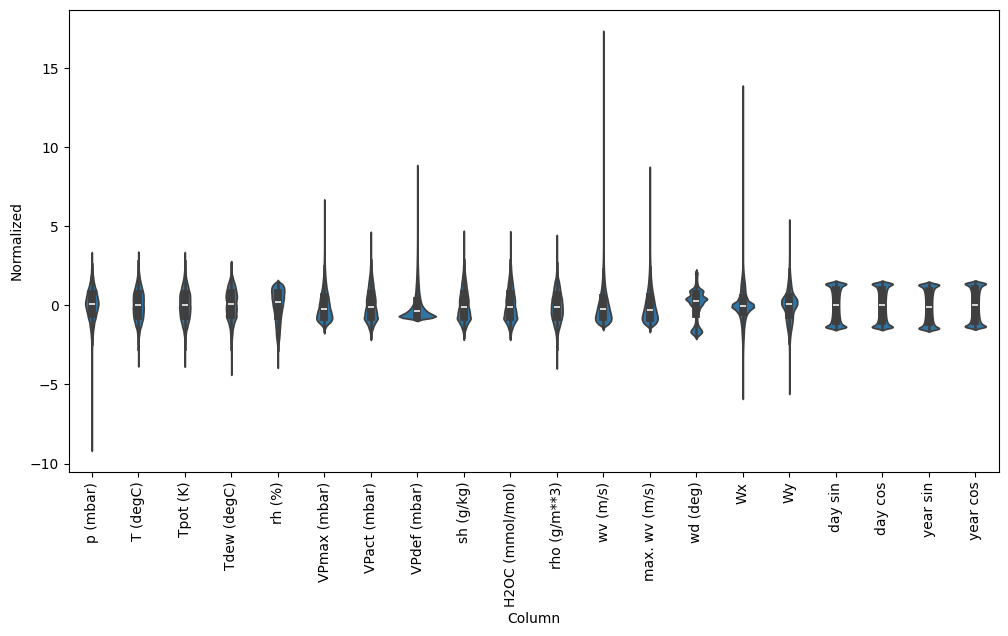

In [13]:
# normalize the data
train_std = train_df.std()
train_mean = train_df.mean() 

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_normalized = (df - train_mean) / train_std
df_normalized = df_normalized.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_normalized)
ax.set_xticklabels(df.keys(), rotation=90)

In [14]:
df_normalized

,Column,Normalized
0,p (mbar),0.947798
1,p (mbar),0.953824
2,p (mbar),0.949003
3,p (mbar),0.946592
4,p (mbar),0.946592
...,...,...
8411015,year cos,1.428444
8411016,year cos,1.428443
8411017,year cos,1.428441
8411018,year cos,1.428439


In [15]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        # Store data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_column_indices = { name: i for i, name in enumerate(label_columns)}
        self.column_indices = { name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label columns names: {self.label_columns}'])

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels


    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normalized]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_column_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

            plt.xlabel('Time [10min]')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32)
        ds = ds.map(self.split_window)
        return ds

# Single Step Models

In [16]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1,
                          train_df=train_df,
                          test_df=test_df,
                          val_df=val_df,
                          label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label columns names: ['T (degC)']

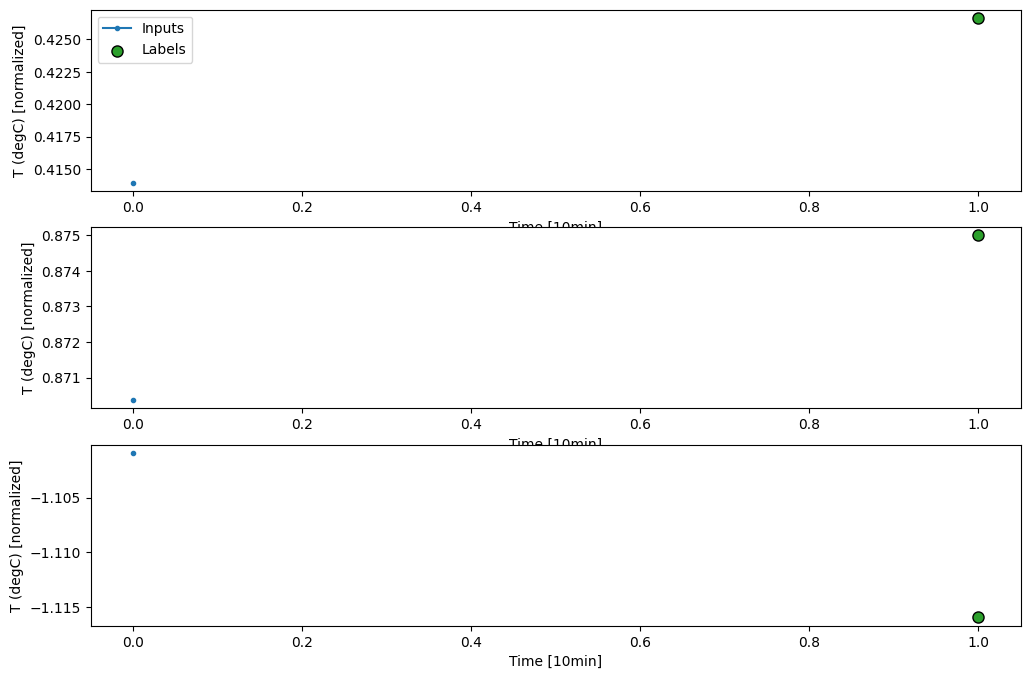

In [17]:
single_step_window.plot()

In [18]:
class Baseline(tf.keras.Model):
    # Baseline model that predicts the temp as not changing
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [19]:
baseline = Baseline(label_index=single_step_window.column_indices['T (degC)'])
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['baseline'] = baseline.evaluate(single_step_window.val)
performance['baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

2629/2629 [==============================] - 5s 2ms/step - loss: 7.7077e-04 - mean_absolute_error: 0.0180


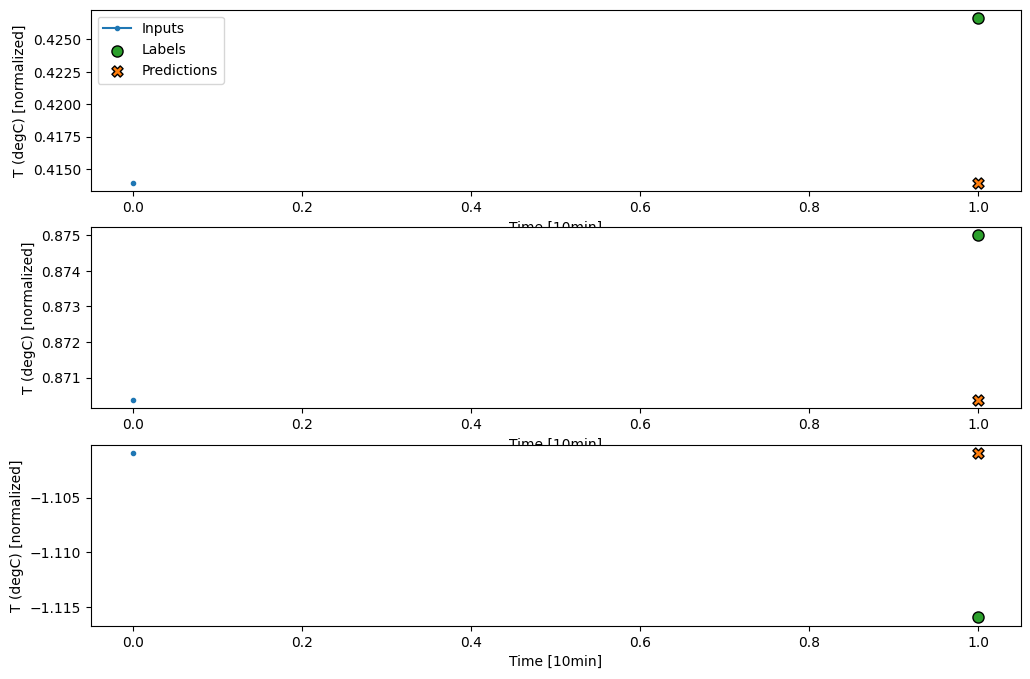

In [20]:
single_step_window.plot(baseline)

In [21]:
wide_window = WindowGenerator(
    input_width=50, label_width=50, shift=1,
    train_df=train_df,
    test_df=test_df,
    val_df=val_df,
    label_columns=['T (degC)'])

wide_window

Total window size: 51
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Label columns names: ['T (degC)']

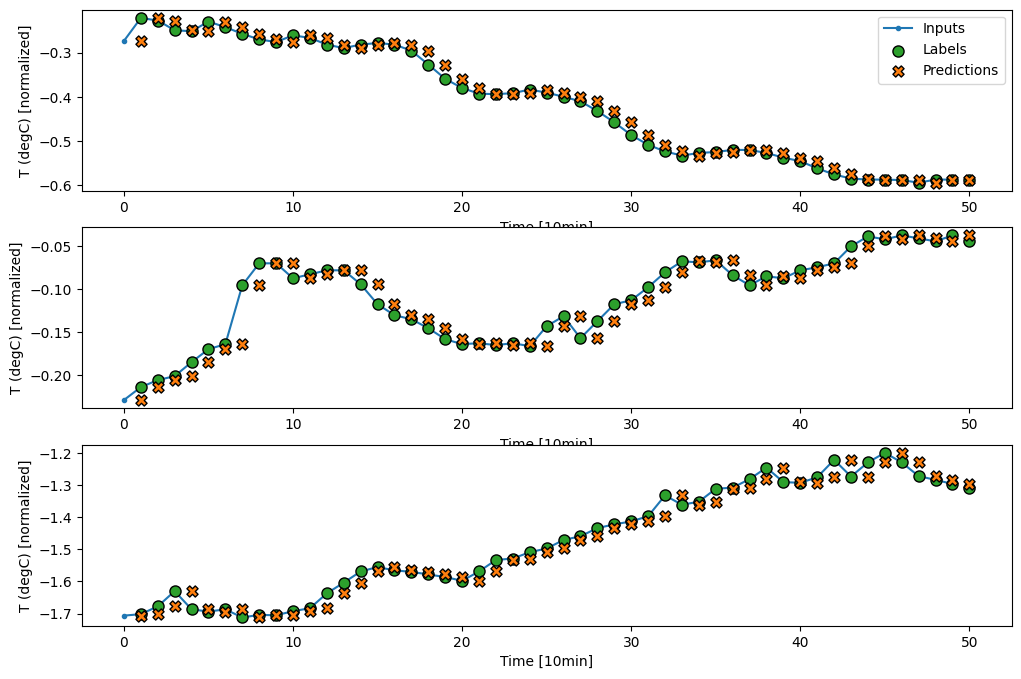

In [22]:
wide_window.plot(baseline)

## Linear Model

In [21]:
MAX_EPOCHS = 20
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
    ])

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    model.compile(  loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [24]:
history = compile_and_fit(linear, single_step_window)

val_performance['linear'] = linear.evaluate(single_step_window.val)
performance['linear'] = linear.evaluate(single_step_window.test)

Epoch 1/20
9200/9200 [==============================] - 26s 3ms/step - loss: 0.0268 - mean_absolute_error: 0.0603 - val_loss: 6.8122e-04 - val_mean_absolute_error: 0.0178
Epoch 2/20
9200/9200 [==============================] - 25s 3ms/step - loss: 7.4440e-04 - mean_absolute_error: 0.0188 - val_loss: 6.9071e-04 - val_mean_absolute_error: 0.0178
Epoch 3/20
9200/9200 [==============================] - 25s 3ms/step - loss: 7.4293e-04 - mean_absolute_error: 0.0188 - val_loss: 6.7534e-04 - val_mean_absolute_error: 0.0178
Epoch 4/20
9200/9200 [==============================] - 25s 3ms/step - loss: 7.4399e-04 - mean_absolute_error: 0.0189 - val_loss: 6.7991e-04 - val_mean_absolute_error: 0.0176
Epoch 5/20
1315/1315 [==============================] - 3s 2ms/step - loss: 7.4627e-04 - mean_absolute_error: 0.0189


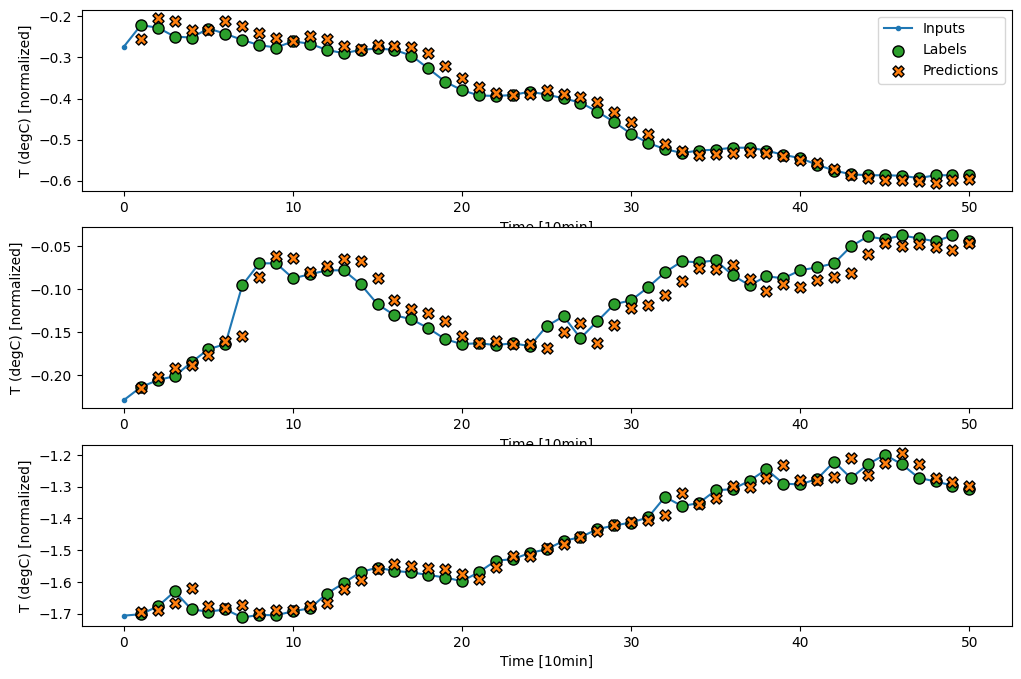

In [25]:
wide_window.plot(linear)

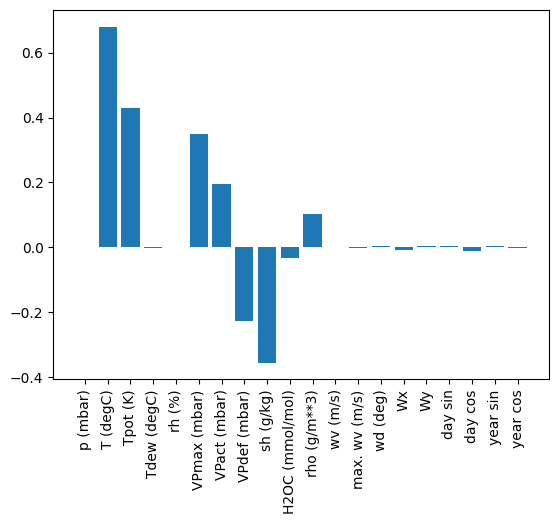

In [26]:
plt.bar(x=range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
ax = plt.gca()

ax.set_xticks(range(len(train_df.columns)))
_ = ax.set_xticklabels(train_df.columns, rotation=90)

## Dense
Stack a few dense layers between in- and output

In [27]:
dense =tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
history = compile_and_fit(dense, single_step_window)

val_performance['dense'] = dense.evaluate(single_step_window.val)
performance['dense'] = dense.evaluate(single_step_window.test)

Epoch 1/20
9200/9200 [==============================] - 32s 3ms/step - loss: 0.0036 - mean_absolute_error: 0.0298 - val_loss: 9.1517e-04 - val_mean_absolute_error: 0.0222
Epoch 2/20
9200/9200 [==============================] - 29s 3ms/step - loss: 7.9557e-04 - mean_absolute_error: 0.0199 - val_loss: 6.3776e-04 - val_mean_absolute_error: 0.0170
Epoch 3/20
9200/9200 [==============================] - 29s 3ms/step - loss: 7.2743e-04 - mean_absolute_error: 0.0187 - val_loss: 6.5595e-04 - val_mean_absolute_error: 0.0177
Epoch 4/20
1315/1315 [==============================] - 3s 2ms/step - loss: 6.9803e-04 - mean_absolute_error: 0.0182


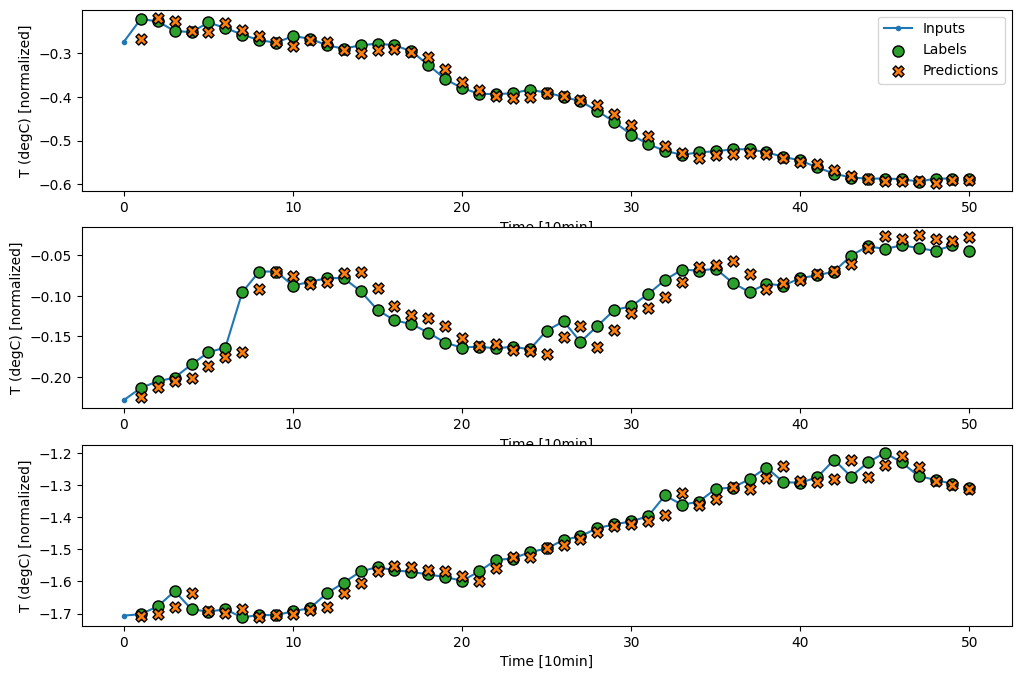

In [28]:
wide_window.plot(dense)

## Multistep dense
t=[0,2] as input and t=3 as output

In [31]:
CONV_WIDTH = 3

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'],
    train_df=train_df,
    test_df=test_df,
    val_df=val_df
)

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label columns names: ['T (degC)']

In [32]:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

multi_step_dense

In [33]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['multistep_dense'] = multi_step_dense.evaluate(conv_window.val)
performance['multistep_dense'] = multi_step_dense.evaluate(conv_window.test)

Epoch 1/20
9200/9200 [==============================] - 31s 3ms/step - loss: 0.0046 - mean_absolute_error: 0.0343 - val_loss: 7.7108e-04 - val_mean_absolute_error: 0.0198
Epoch 2/20
9200/9200 [==============================] - 29s 3ms/step - loss: 7.5912e-04 - mean_absolute_error: 0.0195 - val_loss: 6.6784e-04 - val_mean_absolute_error: 0.0177
Epoch 3/20
9200/9200 [==============================] - 29s 3ms/step - loss: 6.8754e-04 - mean_absolute_error: 0.0184 - val_loss: 7.0719e-04 - val_mean_absolute_error: 0.0189
Epoch 4/20
1315/1315 [==============================] - 3s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0249


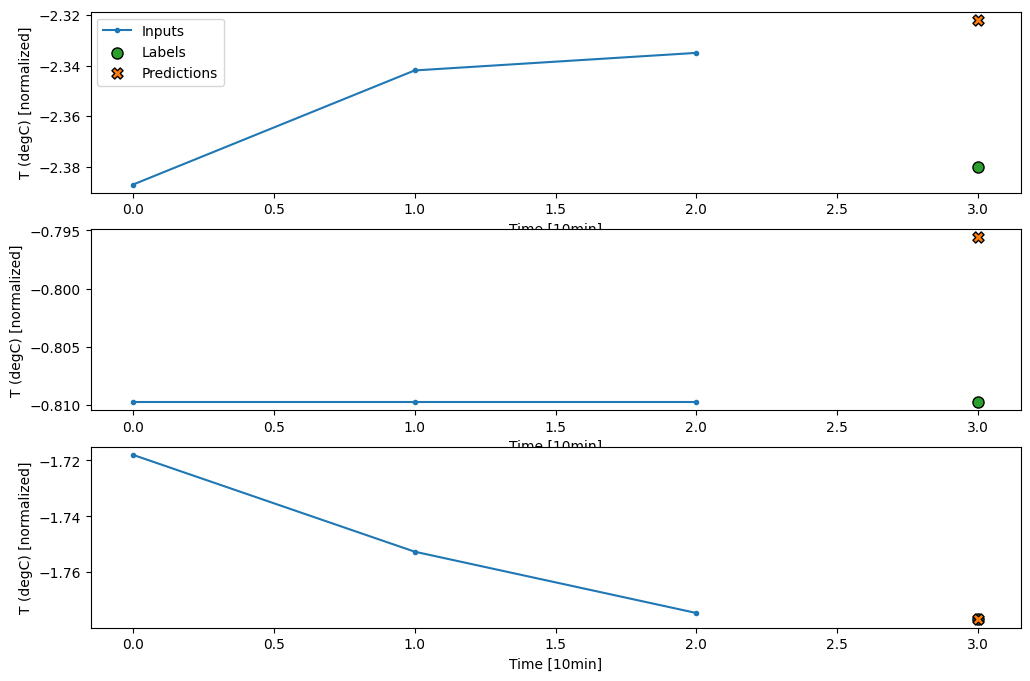

In [34]:
conv_window.plot(multi_step_dense)

## Convolutional Model

In [37]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [38]:
history = compile_and_fit(conv_model, conv_window)



Epoch 1/20
9200/9200 [==============================] - 41s 4ms/step - loss: 0.0031 - mean_absolute_error: 0.0300 - val_loss: 6.6934e-04 - val_mean_absolute_error: 0.0178
Epoch 2/20
9200/9200 [==============================] - 36s 4ms/step - loss: 7.5018e-04 - mean_absolute_error: 0.0194 - val_loss: 6.3433e-04 - val_mean_absolute_error: 0.0179
Epoch 3/20
9200/9200 [==============================] - 36s 4ms/step - loss: 6.7158e-04 - mean_absolute_error: 0.0183 - val_loss: 5.4351e-04 - val_mean_absolute_error: 0.0158
Epoch 4/20
9200/9200 [==============================] - 36s 4ms/step - loss: 6.4443e-04 - mean_absolute_error: 0.0178 - val_loss: 5.4082e-04 - val_mean_absolute_error: 0.0157
Epoch 5/20
9200/9200 [==============================] - 38s 4ms/step - loss: 6.2377e-04 - mean_absolute_error: 0.0175 - val_loss: 5.3194e-04 - val_mean_absolute_error: 0.0155
Epoch 6/20
9200/9200 [==============================] - 38s 4ms/step - loss: 6.1341e-04 - mean_absolute_error: 0.0173 - val_loss:

AttributeError: 'Sequential' object has no attribute 'test'

In [39]:
val_performance['convolutional'] = conv_model.evaluate(conv_window.val)
performance['convolutional'] = conv_model.evaluate(conv_window.test)

1315/1315 [==============================] - 4s 3ms/step - loss: 5.9826e-04 - mean_absolute_error: 0.0173


In [40]:
performance

{'baseline': [0.000857398787047714, 0.019687648862600327],
 'linear': [0.0007462687790393829, 0.018930595368146896],
 'dense': [0.0006980278994888067, 0.018189718946814537],
 'multistep_dense': [0.0012123184278607368, 0.024873359128832817],
 'convolutional': [0.0005982628208585083, 0.01731713116168976]}

In [42]:
LABEL_WIDTH = 40
INPUT_WIDTH = LABEL_WIDTH + CONV_WIDTH - 1
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'],
    test_df=test_df,
    train_df=train_df,
    val_df=val_df)

wide_conv_window

Total window size: 43
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
Label columns names: ['T (degC)']

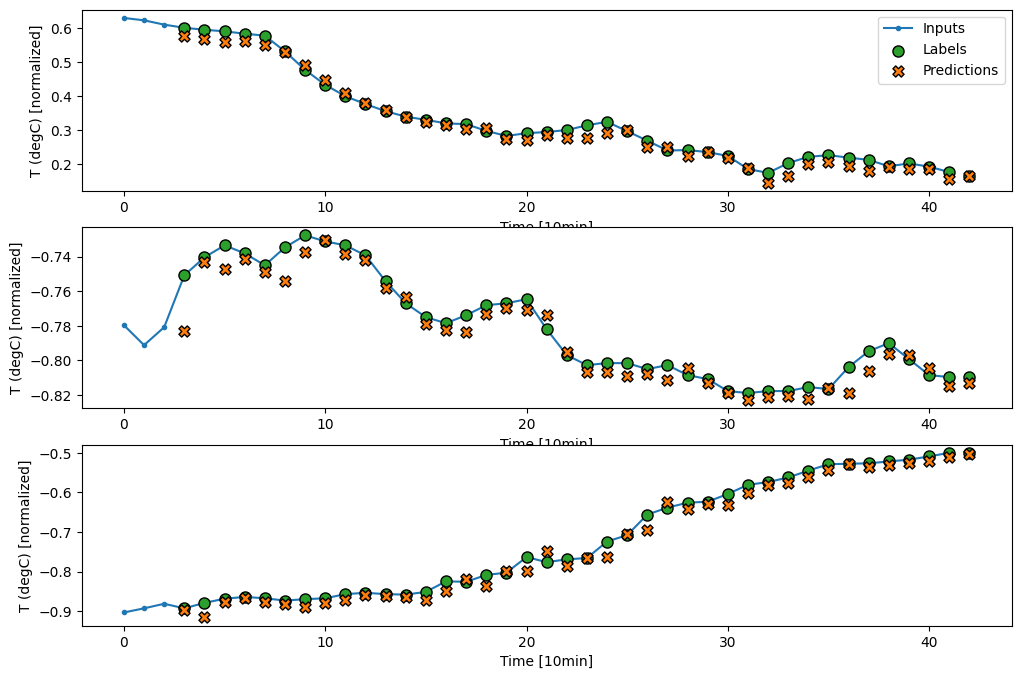

In [43]:
wide_conv_window.plot(conv_model)

## RNN (LSTM)

In [45]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

In [46]:
history = compile_and_fit(lstm_model, wide_window)

val_performance['lstm'] = lstm_model.evaluate(wide_window.val)
performance['lstm'] = lstm_model.evaluate(wide_window.test)

Epoch 1/20
9198/9198 [==============================] - 249s 27ms/step - loss: 0.0024 - mean_absolute_error: 0.0224 - val_loss: 4.7800e-04 - val_mean_absolute_error: 0.0144
Epoch 2/20
9198/9198 [==============================] - 229s 25ms/step - loss: 4.8655e-04 - mean_absolute_error: 0.0147 - val_loss: 4.5440e-04 - val_mean_absolute_error: 0.0138
Epoch 3/20
9198/9198 [==============================] - 229s 25ms/step - loss: 4.6698e-04 - mean_absolute_error: 0.0143 - val_loss: 4.6373e-04 - val_mean_absolute_error: 0.0144
Epoch 4/20
9198/9198 [==============================] - 249s 27ms/step - loss: 4.5619e-04 - mean_absolute_error: 0.0142 - val_loss: 4.3897e-04 - val_mean_absolute_error: 0.0136
Epoch 5/20
9198/9198 [==============================] - 239s 26ms/step - loss: 4.4860e-04 - mean_absolute_error: 0.0140 - val_loss: 4.3671e-04 - val_mean_absolute_error: 0.0134
Epoch 6/20
9198/9198 [==============================] - 239s 26ms/step - loss: 4.4333e-04 - mean_absolute_error: 0.0139

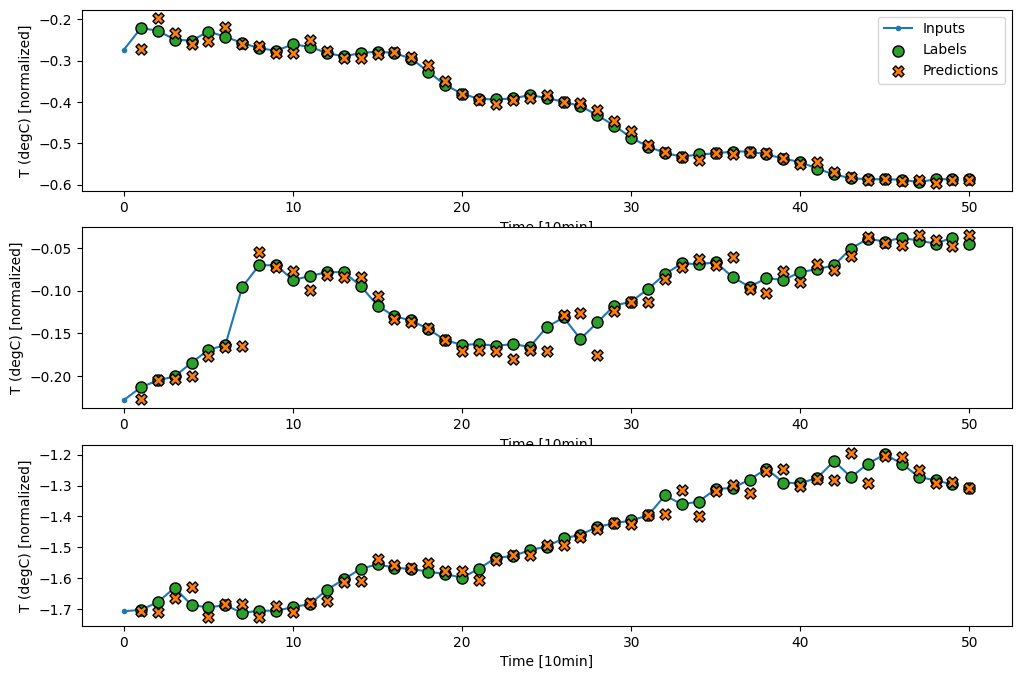

In [47]:
wide_window.plot(lstm_model)

baseline    : 0.0197
linear      : 0.0189
dense       : 0.0182
multistep_dense: 0.0249
convolutional: 0.0173
lstm        : 0.0147


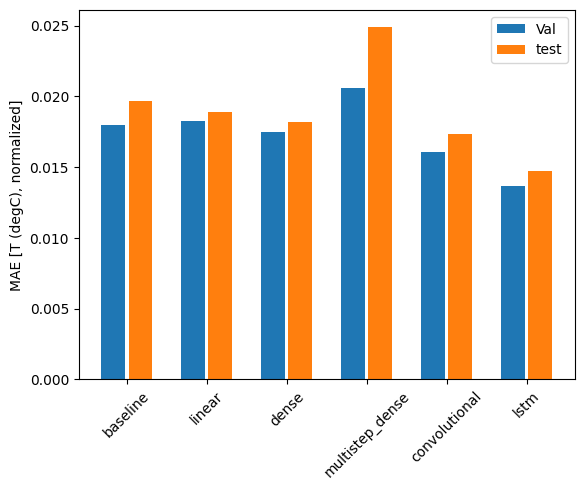

In [50]:
# Performance of Single Step Models
x = np.arange(len(performance))
width = .3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('MAE [T (degC), normalized]')
plt.bar(x-.17, val_mae, width, label='Val')
plt.bar(x+.17, test_mae, width, label='test')

plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()

for name, val in performance.items():
    print(f"{name:12s}: {val[1]:0.4f}")

# Multi Output Models
Adjust the single output models by changing the units in the output layer to multi output models.

In [54]:
single_step_mo_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df,
    test_df=test_df,
    val_df=val_df
    # returns all features if label_columns is not set
)

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label columns names: ['T (degC)']

In [55]:
wide_mo_window = WindowGenerator(
    input_width=40, label_width=40, shift=1,
    train_df=train_df,
    test_df=test_df,
    val_df=val_df
)

wide_mo_window

Total window size: 41
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Label columns names: None

In [56]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {} 

mo_val_performance['baseline'] = baseline.evaluate(wide_mo_window.val)
mo_performance['baseline'] = baseline.evaluate(wide_mo_window.test)


1313/1313 [==============================] - 3s 2ms/step - loss: 0.0547 - mean_absolute_error: 0.0835


In [57]:
dense_mo = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=n_features)
])

In [58]:
%%time
history = compile_and_fit(dense_mo, single_step_mo_window)

Epoch 1/20
9200/9200 [==============================] - 35s 4ms/step - loss: 0.0536 - mean_absolute_error: 0.1091 - val_loss: 0.0450 - val_mean_absolute_error: 0.0901
Epoch 2/20
9200/9200 [==============================] - 34s 4ms/step - loss: 0.0447 - mean_absolute_error: 0.0888 - val_loss: 0.0441 - val_mean_absolute_error: 0.0874
Epoch 3/20
9200/9200 [==============================] - 34s 4ms/step - loss: 0.0441 - mean_absolute_error: 0.0864 - val_loss: 0.0439 - val_mean_absolute_error: 0.0861
Epoch 4/20
9200/9200 [==============================] - 34s 4ms/step - loss: 0.0438 - mean_absolute_error: 0.0854 - val_loss: 0.0439 - val_mean_absolute_error: 0.0844
Epoch 5/20
9200/9200 [==============================] - 34s 4ms/step - loss: 0.0436 - mean_absolute_error: 0.0850 - val_loss: 0.0438 - val_mean_absolute_error: 0.0840
Epoch 6/20
9200/9200 [==============================] - 34s 4ms/step - loss: 0.0435 - mean_absolute_error: 0.0847 - val_loss: 0.0435 - val_mean_absolute_error: 0.085

In [59]:
mo_val_performance['dense'] = dense_mo.evaluate(wide_mo_window.val)
mo_performance['dense'] = dense_mo.evaluate(wide_mo_window.test)

1313/1313 [==============================] - 5s 4ms/step - loss: 0.0435 - mean_absolute_error: 0.0844


In [60]:
lstm_mo = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=n_features)
])

In [62]:
%%time
history = compile_and_fit(lstm_mo, wide_mo_window)

Epoch 1/20
9199/9199 [==============================] - 199s 21ms/step - loss: 0.0540 - mean_absolute_error: 0.1018 - val_loss: 0.0409 - val_mean_absolute_error: 0.0795
Epoch 2/20
9199/9199 [==============================] - 199s 22ms/step - loss: 0.0407 - mean_absolute_error: 0.0789 - val_loss: 0.0402 - val_mean_absolute_error: 0.0773
Epoch 3/20
9199/9199 [==============================] - 204s 22ms/step - loss: 0.0403 - mean_absolute_error: 0.0776 - val_loss: 0.0402 - val_mean_absolute_error: 0.0771
Epoch 4/20
9199/9199 [==============================] - 213s 23ms/step - loss: 0.0400 - mean_absolute_error: 0.0770 - val_loss: 0.0401 - val_mean_absolute_error: 0.0768
Epoch 5/20
9199/9199 [==============================] - 213s 23ms/step - loss: 0.0399 - mean_absolute_error: 0.0766 - val_loss: 0.0398 - val_mean_absolute_error: 0.0760
Epoch 6/20
9199/9199 [==============================] - 213s 23ms/step - loss: 0.0398 - mean_absolute_error: 0.0763 - val_loss: 0.0398 - val_mean_absolute_

In [63]:
mo_val_performance['lstm'] = lstm_mo.evaluate(wide_mo_window.val)
mo_performance['lstm'] = lstm_mo.evaluate(wide_mo_window.test)

1313/1313 [==============================] - 10s 8ms/step - loss: 0.0399 - mean_absolute_error: 0.0766


## Residual connections
Residual connections help if you know that the change for each step should be small. Thus the model should only predict the delta from one step to another. This leads to faster convergence for problems where the assumption is true.

In [73]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)
        return inputs + delta

In [74]:
residual_model = ResidualWrapper(
    tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(units=n_features)
]))

In [75]:
%%time
history = compile_and_fit(residual_model, wide_mo_window)

Epoch 1/20
9199/9199 [==============================] - 202s 22ms/step - loss: 0.0418 - mean_absolute_error: 0.0781 - val_loss: 0.0404 - val_mean_absolute_error: 0.0740
Epoch 2/20
9199/9199 [==============================] - 198s 21ms/step - loss: 0.0398 - mean_absolute_error: 0.0742 - val_loss: 0.0401 - val_mean_absolute_error: 0.0737
Epoch 3/20
9199/9199 [==============================] - 196s 21ms/step - loss: 0.0395 - mean_absolute_error: 0.0739 - val_loss: 0.0401 - val_mean_absolute_error: 0.0737
Epoch 4/20
9199/9199 [==============================] - 197s 21ms/step - loss: 0.0393 - mean_absolute_error: 0.0739 - val_loss: 0.0401 - val_mean_absolute_error: 0.0736
Epoch 5/20
9199/9199 [==============================] - 210s 23ms/step - loss: 0.0391 - mean_absolute_error: 0.0738 - val_loss: 0.0402 - val_mean_absolute_error: 0.0737
CPU times: user 45min 1s, sys: 5min 7s, total: 50min 8s
Wall time: 16min 44s


In [76]:
mo_val_performance['res_lstm'] = residual_model.evaluate(wide_mo_window.val)
mo_performance['res_lstm'] = residual_model.evaluate(wide_mo_window.test)

1313/1313 [==============================] - 12s 9ms/step - loss: 0.0401 - mean_absolute_error: 0.0752


baseline    : 0.0835
dense       : 0.0844
lstm        : 0.0766
res_lstm    : 0.0752


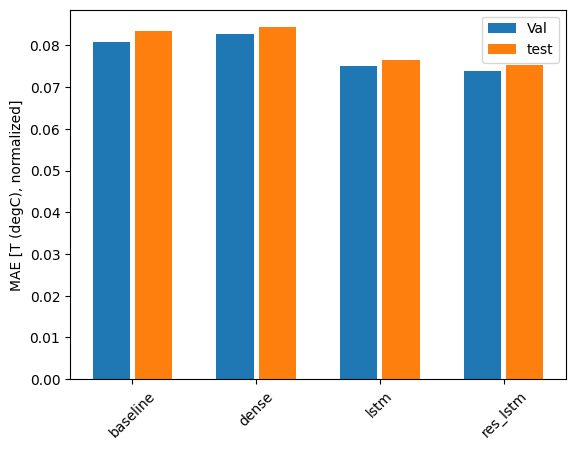

In [78]:
# Performance of Single Step Models
x = np.arange(len(mo_performance))
width = .3
metric_name = 'mean_absolute_error'
metric_index = lstm_mo.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in mo_val_performance.values()]
test_mae = [v[metric_index] for v in mo_performance.values()]

plt.ylabel('MAE [over all outputs]')
plt.bar(x-.17, val_mae, width, label='Val')
plt.bar(x+.17, test_mae, width, label='test')

plt.xticks(ticks=x, labels=mo_performance.keys(), rotation=45)
_ = plt.legend()

for name, val in mo_performance.items():
    print(f"{name:12s}: {val[1]:0.4f}")

# Multi Step Models
Both presented models, single step and multi-output models just make a single step prediction into the future. Now we expand the models to multi step models, which make predictions multiple steps into the future.

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label columns names: None

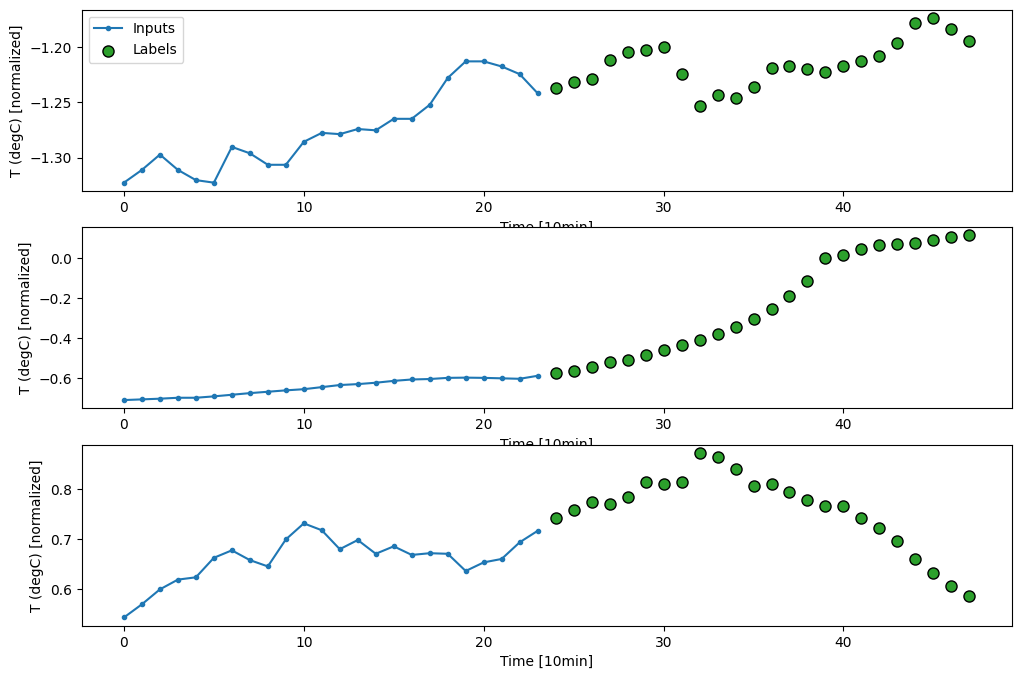

In [16]:
OUT_STEPS = 24
multi_window = WindowGenerator(
    input_width=24,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df
)

multi_window.plot()
multi_window

## Baselines
Now we implement two baselines models, one that just repeats the last value and one that repeats the last window

1313/1313 [==============================] - 3s 2ms/step - loss: 0.2271 - mean_absolute_error: 0.2651


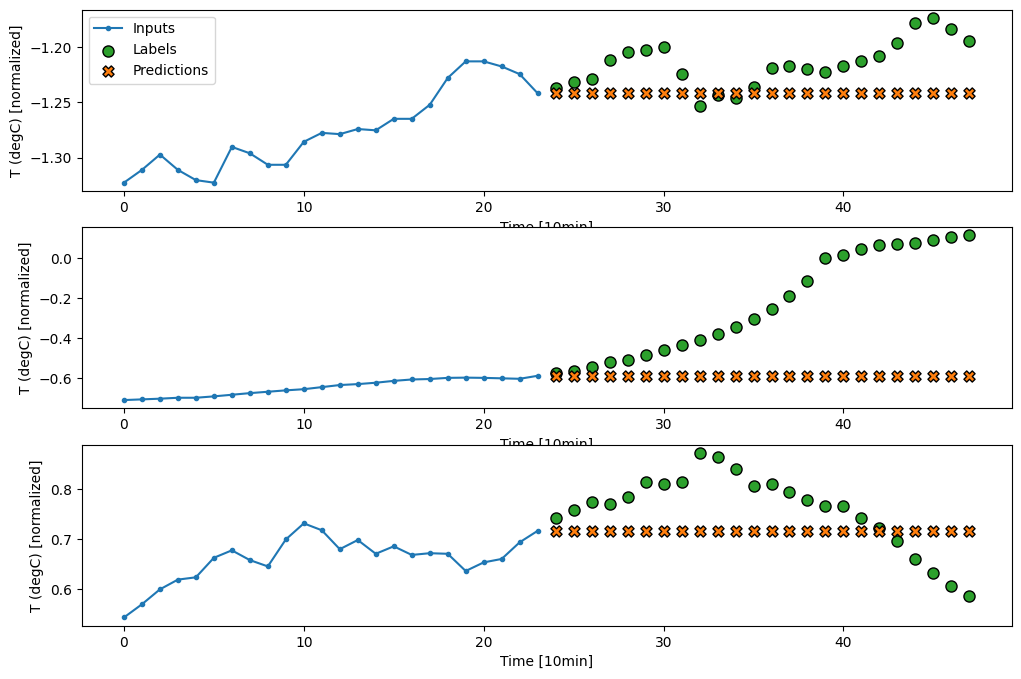

In [17]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['last'] = last_baseline.evaluate(multi_window.val)
multi_performance['last'] = last_baseline.evaluate(multi_window.test)

multi_window.plot(last_baseline)

1313/1313 [==============================] - 3s 2ms/step - loss: 0.4170 - mean_absolute_error: 0.4057


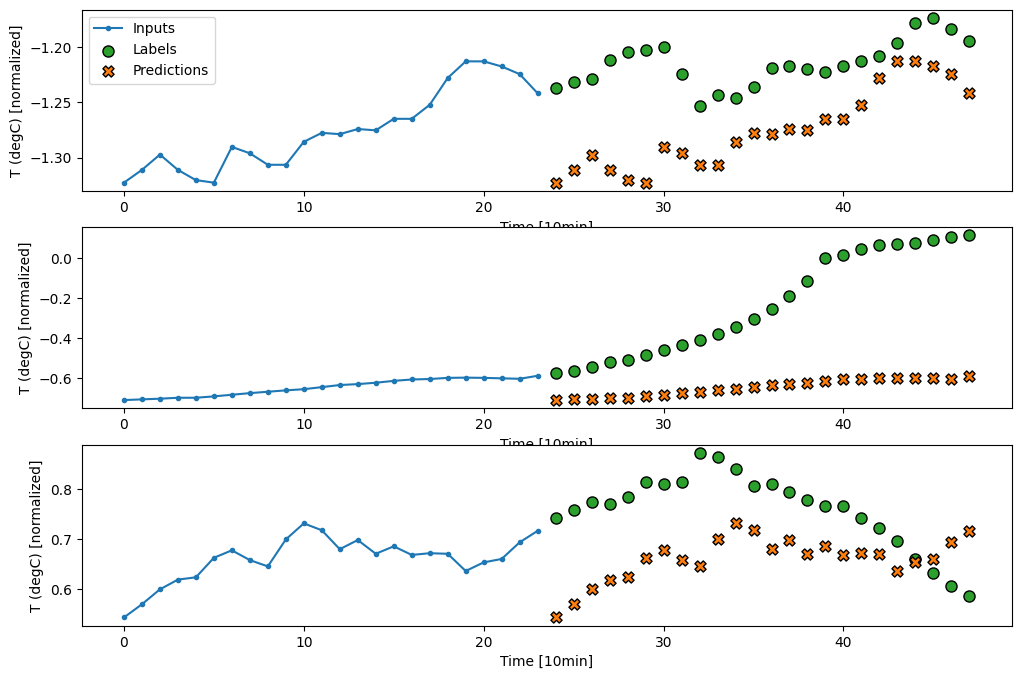

In [31]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['repeat'] = repeat_baseline.evaluate(multi_window.test)

multi_window.plot(repeat_baseline)

## Single Shot Models
### linear model

In [32]:
multi_linear_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),  # take the last timestep
    tf.keras.layers.Dense(OUT_STEPS*n_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, n_features])
])

In [33]:
%%time
history = compile_and_fit(multi_linear_model, multi_window)

Epoch 1/20
9199/9199 [==============================] - 34s 4ms/step - loss: 0.1546 - mean_absolute_error: 0.2143 - val_loss: 0.1396 - val_mean_absolute_error: 0.1918
Epoch 2/20
9199/9199 [==============================] - 33s 4ms/step - loss: 0.1398 - mean_absolute_error: 0.1937 - val_loss: 0.1395 - val_mean_absolute_error: 0.1917
Epoch 3/20
9199/9199 [==============================] - 32s 3ms/step - loss: 0.1397 - mean_absolute_error: 0.1936 - val_loss: 0.1394 - val_mean_absolute_error: 0.1916
Epoch 4/20
9199/9199 [==============================] - 33s 4ms/step - loss: 0.1397 - mean_absolute_error: 0.1935 - val_loss: 0.1394 - val_mean_absolute_error: 0.1918
Epoch 5/20
9199/9199 [==============================] - 33s 4ms/step - loss: 0.1397 - mean_absolute_error: 0.1935 - val_loss: 0.1394 - val_mean_absolute_error: 0.1918
CPU times: user 8min 24s, sys: 1min 31s, total: 9min 55s
Wall time: 2min 44s


1313/1313 [==============================] - 4s 3ms/step - loss: 0.1315 - mean_absolute_error: 0.1899


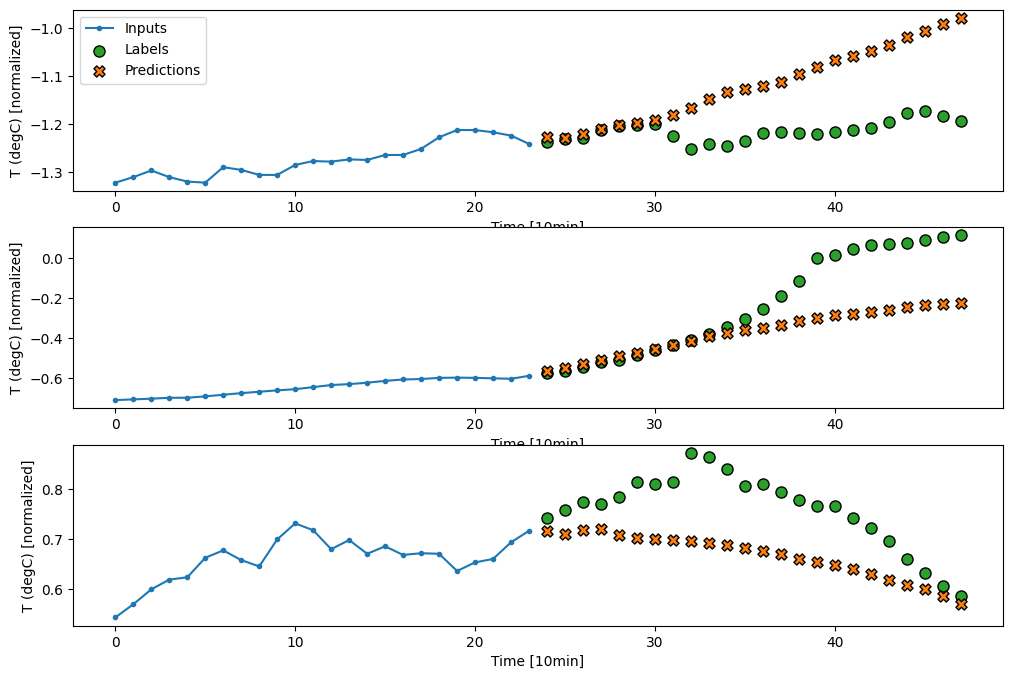

In [34]:
multi_val_performance['linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['linear'] = multi_linear_model.evaluate(multi_window.test)

multi_window.plot(multi_linear_model)

In [35]:
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*n_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, n_features])
])

In [36]:
%%time
history = compile_and_fit(multi_dense_model, multi_window)

Epoch 1/20
9199/9199 [==============================] - 62s 7ms/step - loss: 0.1266 - mean_absolute_error: 0.1849 - val_loss: 0.1244 - val_mean_absolute_error: 0.1824
Epoch 2/20
9199/9199 [==============================] - 65s 7ms/step - loss: 0.1209 - mean_absolute_error: 0.1781 - val_loss: 0.1236 - val_mean_absolute_error: 0.1827
Epoch 3/20
9199/9199 [==============================] - 64s 7ms/step - loss: 0.1194 - mean_absolute_error: 0.1759 - val_loss: 0.1223 - val_mean_absolute_error: 0.1781
Epoch 4/20
9199/9199 [==============================] - 63s 7ms/step - loss: 0.1184 - mean_absolute_error: 0.1743 - val_loss: 0.1236 - val_mean_absolute_error: 0.1792
Epoch 5/20
9199/9199 [==============================] - 63s 7ms/step - loss: 0.1177 - mean_absolute_error: 0.1733 - val_loss: 0.1227 - val_mean_absolute_error: 0.1767
CPU times: user 16min 1s, sys: 2min 55s, total: 18min 57s
Wall time: 5min 16s


1313/1313 [==============================] - 4s 3ms/step - loss: 0.1152 - mean_absolute_error: 0.1744


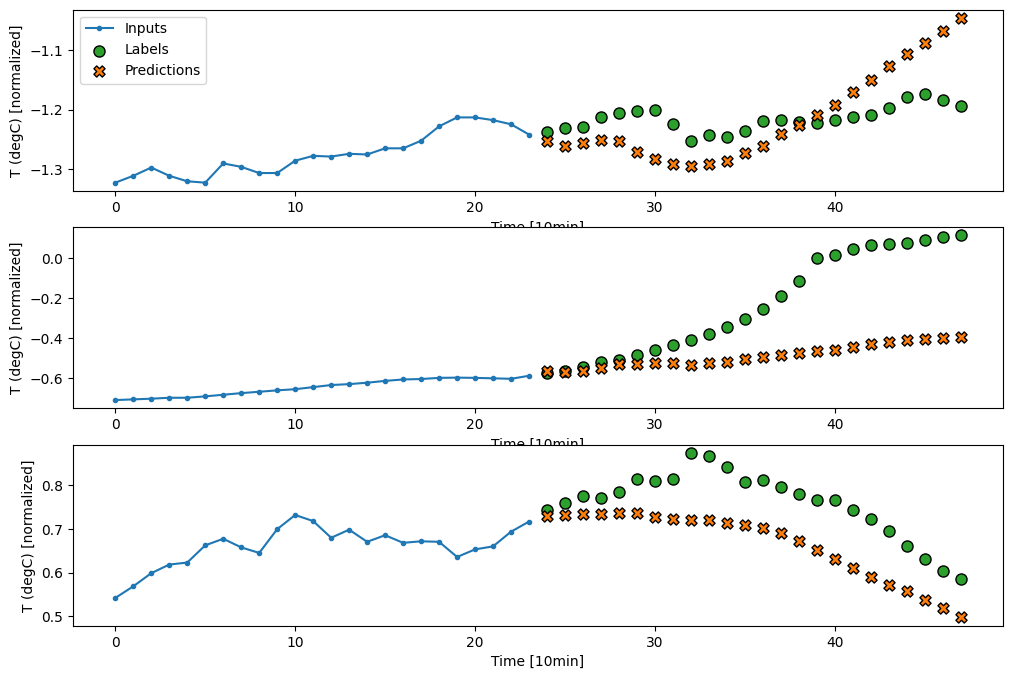

In [37]:
multi_val_performance['dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['dense'] = multi_dense_model.evaluate(multi_window.test)

multi_window.plot(multi_dense_model)

In [38]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*n_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, n_features])
])

In [39]:
%%time
history = compile_and_fit(multi_conv_model, multi_window)

Epoch 1/20
9199/9199 [==============================] - 60s 6ms/step - loss: 0.1253 - mean_absolute_error: 0.1874 - val_loss: 0.1218 - val_mean_absolute_error: 0.1825
Epoch 2/20
9199/9199 [==============================] - 58s 6ms/step - loss: 0.1191 - mean_absolute_error: 0.1789 - val_loss: 0.1201 - val_mean_absolute_error: 0.1787
Epoch 3/20
9199/9199 [==============================] - 57s 6ms/step - loss: 0.1177 - mean_absolute_error: 0.1763 - val_loss: 0.1191 - val_mean_absolute_error: 0.1779
Epoch 4/20
9199/9199 [==============================] - 59s 6ms/step - loss: 0.1167 - mean_absolute_error: 0.1746 - val_loss: 0.1188 - val_mean_absolute_error: 0.1761
Epoch 5/20
9199/9199 [==============================] - 58s 6ms/step - loss: 0.1161 - mean_absolute_error: 0.1737 - val_loss: 0.1192 - val_mean_absolute_error: 0.1769
Epoch 6/20
9199/9199 [==============================] - 58s 6ms/step - loss: 0.1156 - mean_absolute_error: 0.1730 - val_loss: 0.1183 - val_mean_absolute_error: 0.174

1313/1313 [==============================] - 5s 4ms/step - loss: 0.1116 - mean_absolute_error: 0.1724


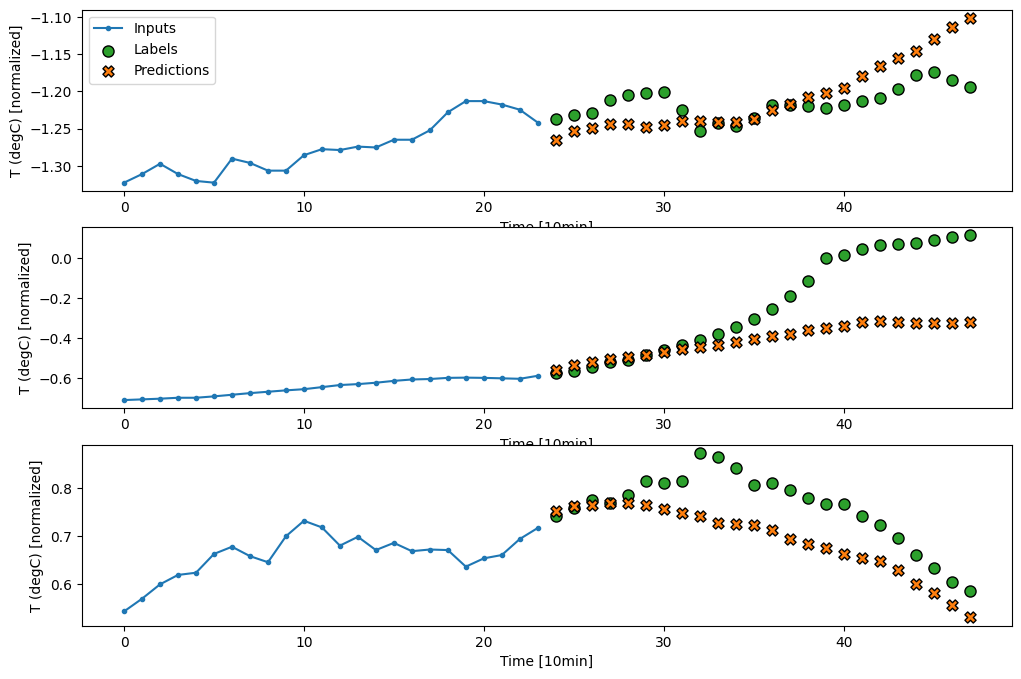

In [40]:
multi_val_performance['conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['conv'] = multi_conv_model.evaluate(multi_window.test)

multi_window.plot(multi_conv_model)

In [41]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*n_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, n_features])
])

In [42]:
%%time
history = compile_and_fit(multi_lstm_model, multi_window)

Epoch 1/20
9199/9199 [==============================] - 161s 17ms/step - loss: 0.1333 - mean_absolute_error: 0.1977 - val_loss: 0.1200 - val_mean_absolute_error: 0.1772
Epoch 2/20
9199/9199 [==============================] - 161s 18ms/step - loss: 0.1151 - mean_absolute_error: 0.1740 - val_loss: 0.1177 - val_mean_absolute_error: 0.1753
Epoch 3/20
9199/9199 [==============================] - 167s 18ms/step - loss: 0.1132 - mean_absolute_error: 0.1719 - val_loss: 0.1163 - val_mean_absolute_error: 0.1733
Epoch 4/20
9199/9199 [==============================] - 155s 17ms/step - loss: 0.1121 - mean_absolute_error: 0.1709 - val_loss: 0.1162 - val_mean_absolute_error: 0.1724
Epoch 5/20
9199/9199 [==============================] - 150s 16ms/step - loss: 0.1114 - mean_absolute_error: 0.1703 - val_loss: 0.1158 - val_mean_absolute_error: 0.1736
Epoch 6/20
9199/9199 [==============================] - 150s 16ms/step - loss: 0.1107 - mean_absolute_error: 0.1698 - val_loss: 0.1160 - val_mean_absolute_

1313/1313 [==============================] - 9s 7ms/step - loss: 0.1082 - mean_absolute_error: 0.1699


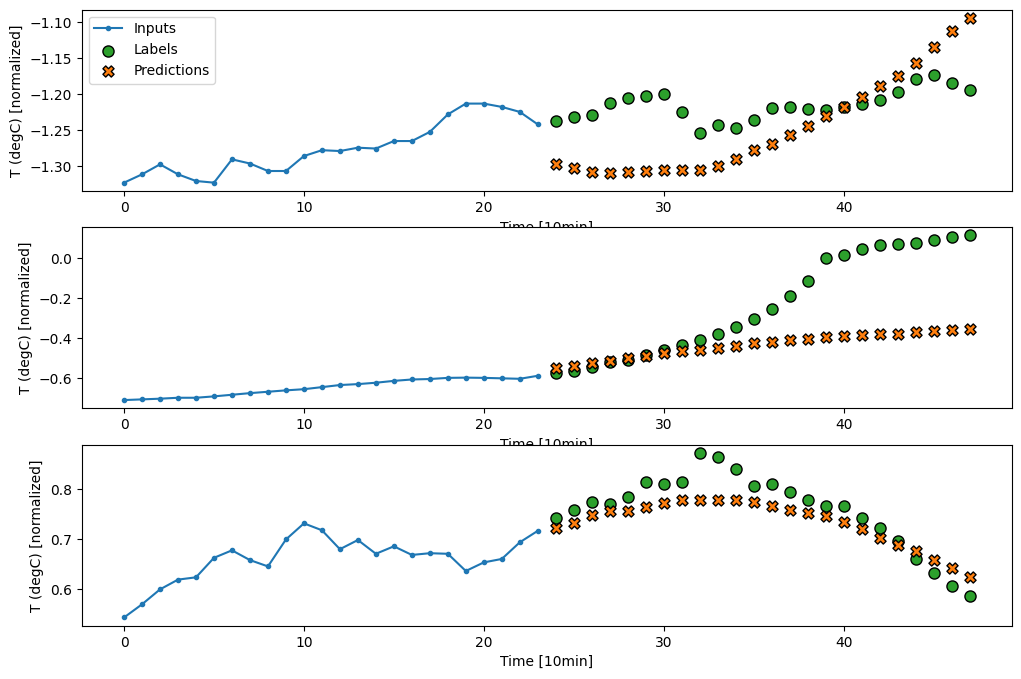

In [43]:
multi_val_performance['lstm'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['lstm'] = multi_lstm_model.evaluate(multi_window.test)

multi_window.plot(multi_lstm_model)

In [23]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense =tf.keras.layers.Dense(n_features)

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)

        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [24]:
lstm_ar_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [25]:
%%time
history = compile_and_fit(lstm_ar_model, multi_window)

Epoch 1/20
9199/9199 [==============================] - 213s 23ms/step - loss: 0.1577 - mean_absolute_error: 0.2380 - val_loss: 0.1280 - val_mean_absolute_error: 0.2024
Epoch 2/20
9199/9199 [==============================] - 198s 22ms/step - loss: 0.1259 - mean_absolute_error: 0.1971 - val_loss: 0.1265 - val_mean_absolute_error: 0.1965
Epoch 3/20
9199/9199 [==============================] - 214s 23ms/step - loss: 0.1220 - mean_absolute_error: 0.1904 - val_loss: 0.1214 - val_mean_absolute_error: 0.1881
Epoch 4/20
9199/9199 [==============================] - 228s 25ms/step - loss: 0.1199 - mean_absolute_error: 0.1870 - val_loss: 0.1204 - val_mean_absolute_error: 0.1856
Epoch 5/20
9199/9199 [==============================] - 221s 24ms/step - loss: 0.1183 - mean_absolute_error: 0.1845 - val_loss: 0.1195 - val_mean_absolute_error: 0.1836
Epoch 6/20
9199/9199 [==============================] - 225s 24ms/step - loss: 0.1171 - mean_absolute_error: 0.1828 - val_loss: 0.1213 - val_mean_absolute_

1313/1313 [==============================] - 11s 8ms/step - loss: 0.1127 - mean_absolute_error: 0.1799


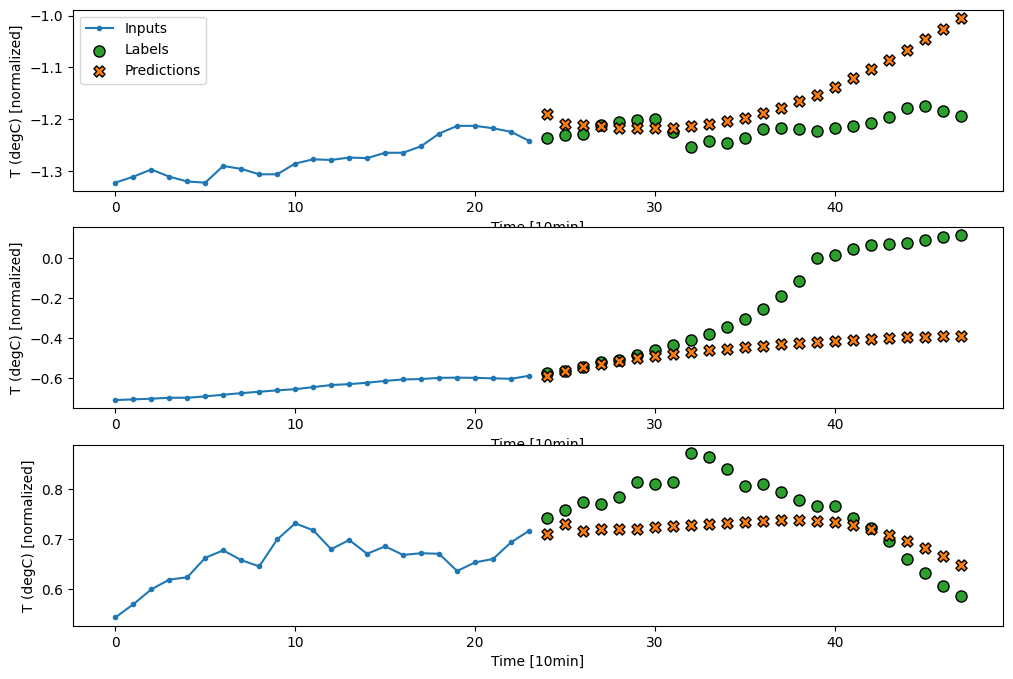

In [44]:
multi_val_performance['lstm_ar'] = lstm_ar_model.evaluate(multi_window.val)
multi_performance['lstm_ar'] = lstm_ar_model.evaluate(multi_window.test)

multi_window.plot(lstm_ar_model)

last        : 0.2651
lstm_ar     : 0.1799
repeat      : 0.4057
linear      : 0.1899
dense       : 0.1744
conv        : 0.1724
lstm        : 0.1699


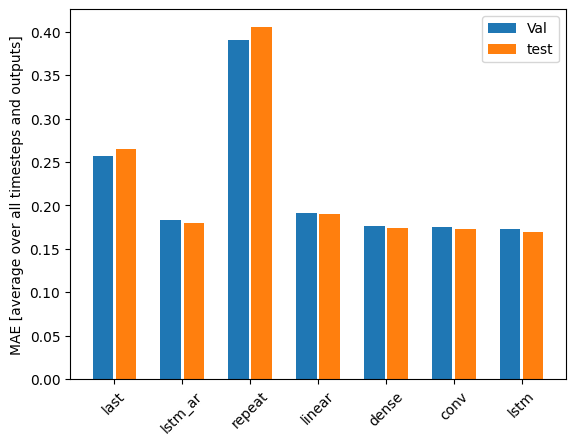

In [45]:
# Performance of Single Step Models
x = np.arange(len(multi_performance))
width = .3
metric_name = 'mean_absolute_error'
metric_index = lstm_ar_model.metrics_names.index(metric_name)
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.ylabel('MAE [average over all timesteps and outputs]')
plt.bar(x-.17, val_mae, width, label='Val')
plt.bar(x+.17, test_mae, width, label='test')

plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
_ = plt.legend()

for name, val in multi_performance.items():
    print(f"{name:12s}: {val[1]:0.4f}")

In [55]:
history.history

{'loss': [0.1333111673593521,
  0.11507302522659302,
  0.11323100328445435,
  0.11210920661687851,
  0.1113600954413414,
  0.1107313260436058,
  0.11020930111408234],
 'mean_absolute_error': [0.19770339131355286,
  0.17404557764530182,
  0.17193196713924408,
  0.17086273431777954,
  0.17026081681251526,
  0.16978001594543457,
  0.1694173961877823],
 'val_loss': [0.11997266858816147,
  0.11765886098146439,
  0.11629083007574081,
  0.11621669679880142,
  0.11575537919998169,
  0.11598442494869232,
  0.11627917736768723],
 'val_mean_absolute_error': [0.17723044753074646,
  0.1753293126821518,
  0.1733182668685913,
  0.17244753241539001,
  0.17356516420841217,
  0.17234033346176147,
  0.172781839966774]}

In [47]:
# TODO: implement transformer model
# TODO: implement SVM Regression as prediction model
